# LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima

plt.rcParams["figure.figsize"] = (30,10)

import yfinance as yf

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import lag_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

# DATA PREPERATION

In [2]:
df = yf.download(tickers='ETH-USD', start="2020-07-01", end="2021-07-01")

[*********************100%***********************]  1 of 1 completed


## First Glance

In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-30,227.968430,229.476807,224.815186,226.315002,226.315002,6094093001
2020-07-01,226.134583,232.756119,224.835739,231.113419,231.113419,6463737443
2020-07-02,231.288910,232.396881,225.461960,229.392197,229.392197,6212210566
2020-07-03,229.318954,229.629318,224.913971,225.387070,225.387070,5109032700
2020-07-04,225.288483,230.054138,225.133316,229.074112,229.074112,5228310135


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,363.0,1.237633e+03,9.662340e+02,2.252885e+02,3.888411e+02,7.314728e+02,1.918915e+03,4.174636e+03
High,363.0,1.291933e+03,1.015391e+03,2.294768e+02,3.989274e+02,7.542994e+02,1.977109e+03,4.362351e+03
Low,363.0,1.176570e+03,9.071960e+02,2.245445e+02,3.803643e+02,7.197922e+02,1.819650e+03,3.785849e+03
Close,363.0,1.243099e+03,9.662841e+02,2.253871e+02,3.890728e+02,7.378034e+02,1.922110e+03,4.168701e+03
Adj Close,363.0,1.243099e+03,9.662841e+02,2.253871e+02,3.890728e+02,7.378034e+02,1.922110e+03,4.168701e+03
Volume,363.0,2.396258e+10,1.399868e+10,5.109033e+09,1.278348e+10,2.106715e+10,3.183429e+10,8.448291e+10


In [5]:
df.isnull().values.any()

False

In [6]:
# Since we will use just "Close" values in that ARIMA model,
df = df["Close"]

## Visualization

<AxesSubplot:title={'center':'ETHUSD values in between 2020-07-01 and 2021-07-01'}, xlabel='Date'>

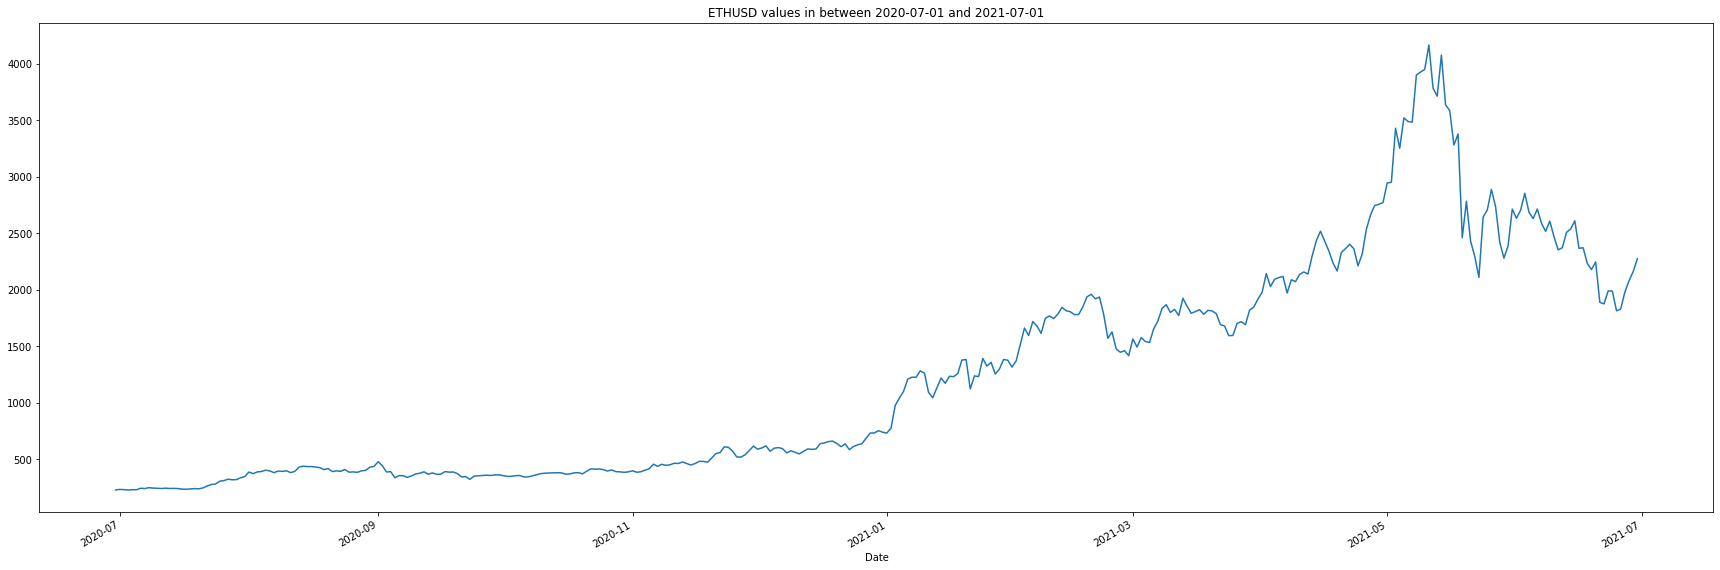

In [7]:
df.plot(title = "ETHUSD values in between 2020-07-01 and 2021-07-01")

# ARIMA MODEL

## Suitibility Control

Text(0.5, 1.0, 'Scatter plot of Closing price')

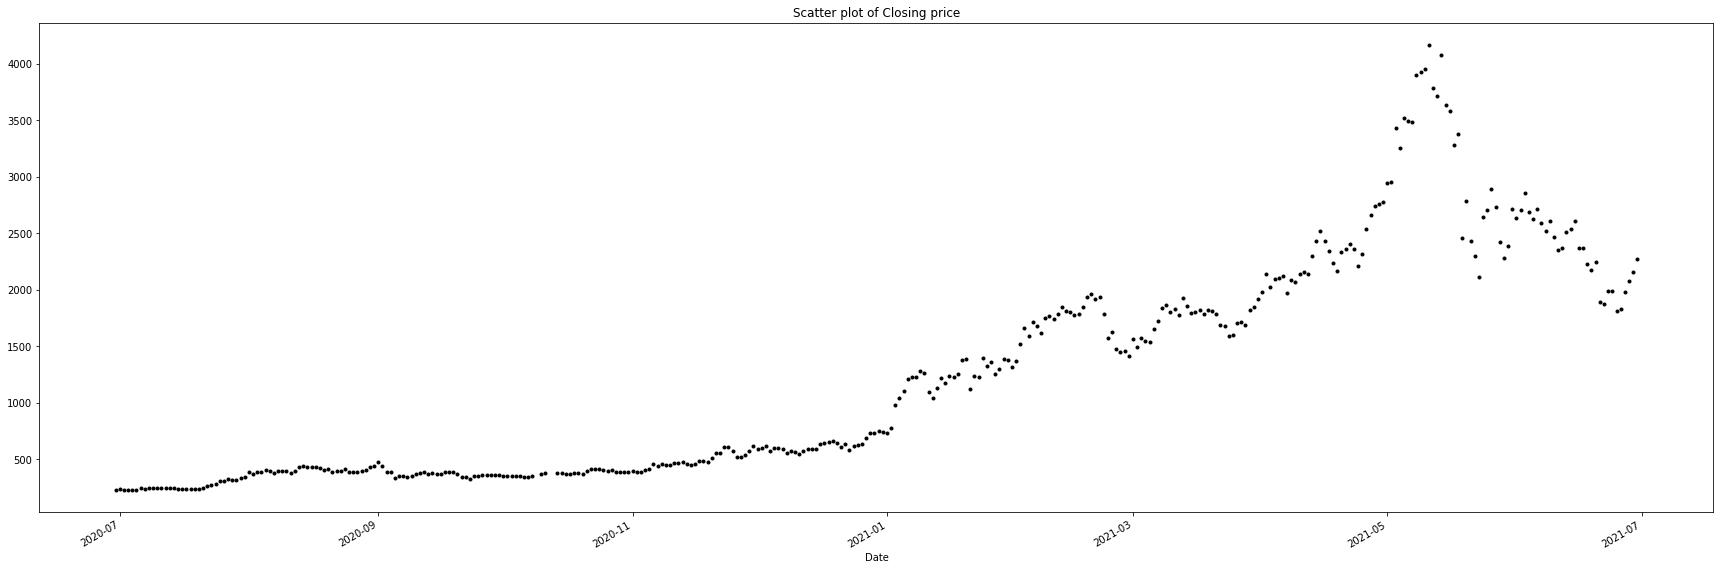

In [8]:
df.plot(style='k.')
plt.title('Scatter plot of Closing price')

<AxesSubplot:ylabel='Density'>

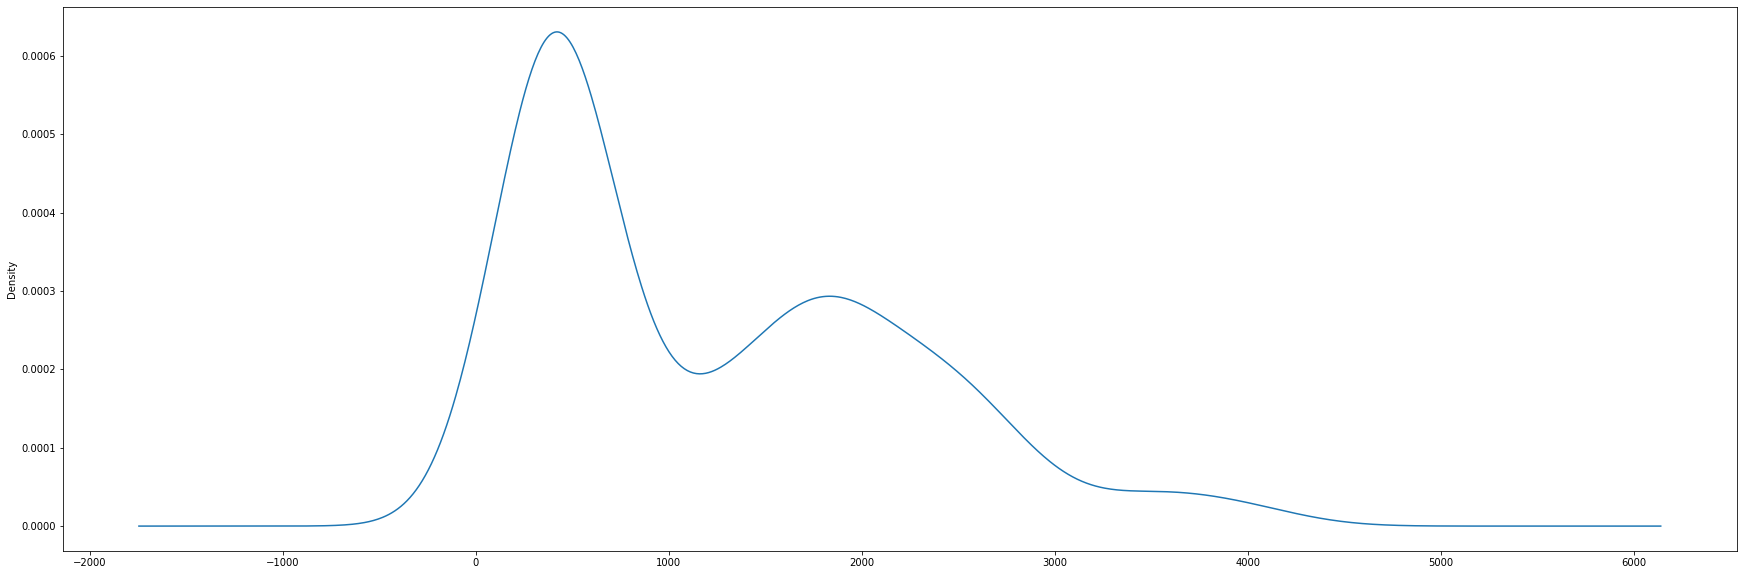

In [9]:
df.plot(kind='kde')

Text(0.5, 1.0, 'ETHUSD - Autocorrelation plot')

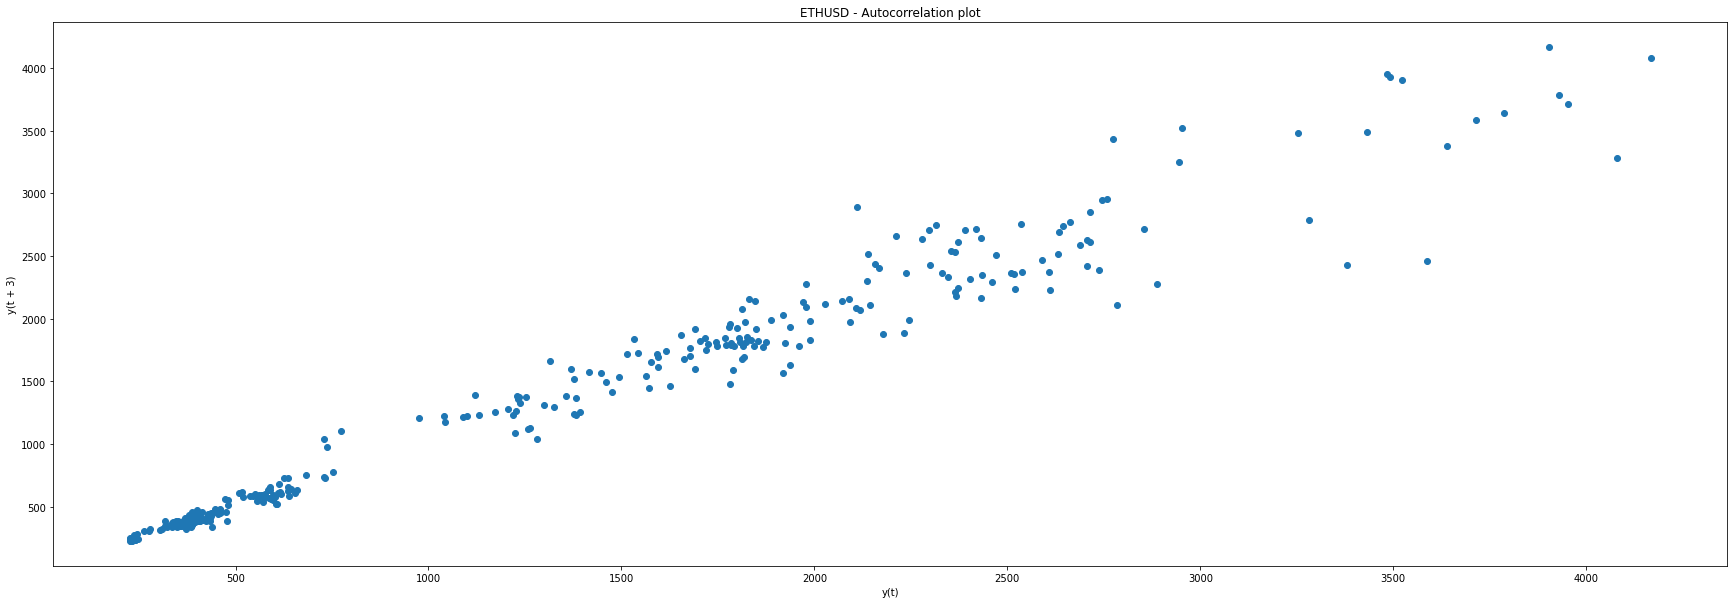

In [10]:
lag_plot(df, lag = 3)
plt.title("ETHUSD - Autocorrelation plot")

In [11]:
# Check if price series is stationary
result = adfuller(df)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -0.8395889503251139
p-value: 0.807215700887671


<Figure size 2160x720 with 0 Axes>

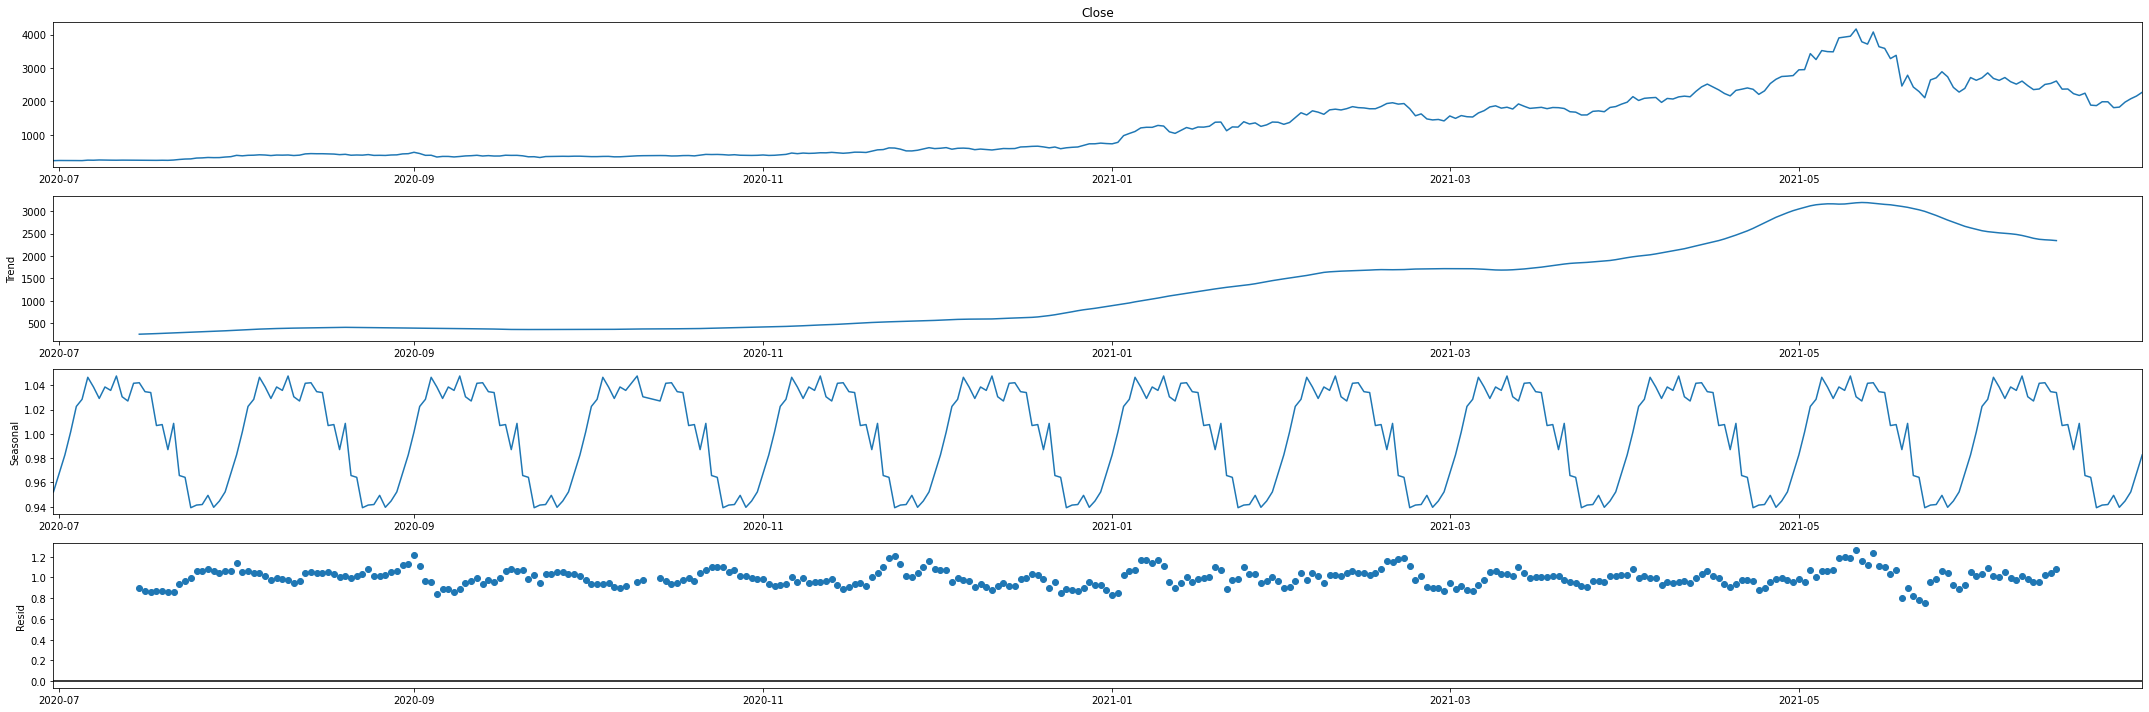

In [12]:
# Since p > 0.05, seasonality must be decomposed
result = seasonal_decompose(df, model = "multiplicative", freq = 30)
fig = plt.figure()  
fig = result.plot()  

No handles with labels found to put in legend.


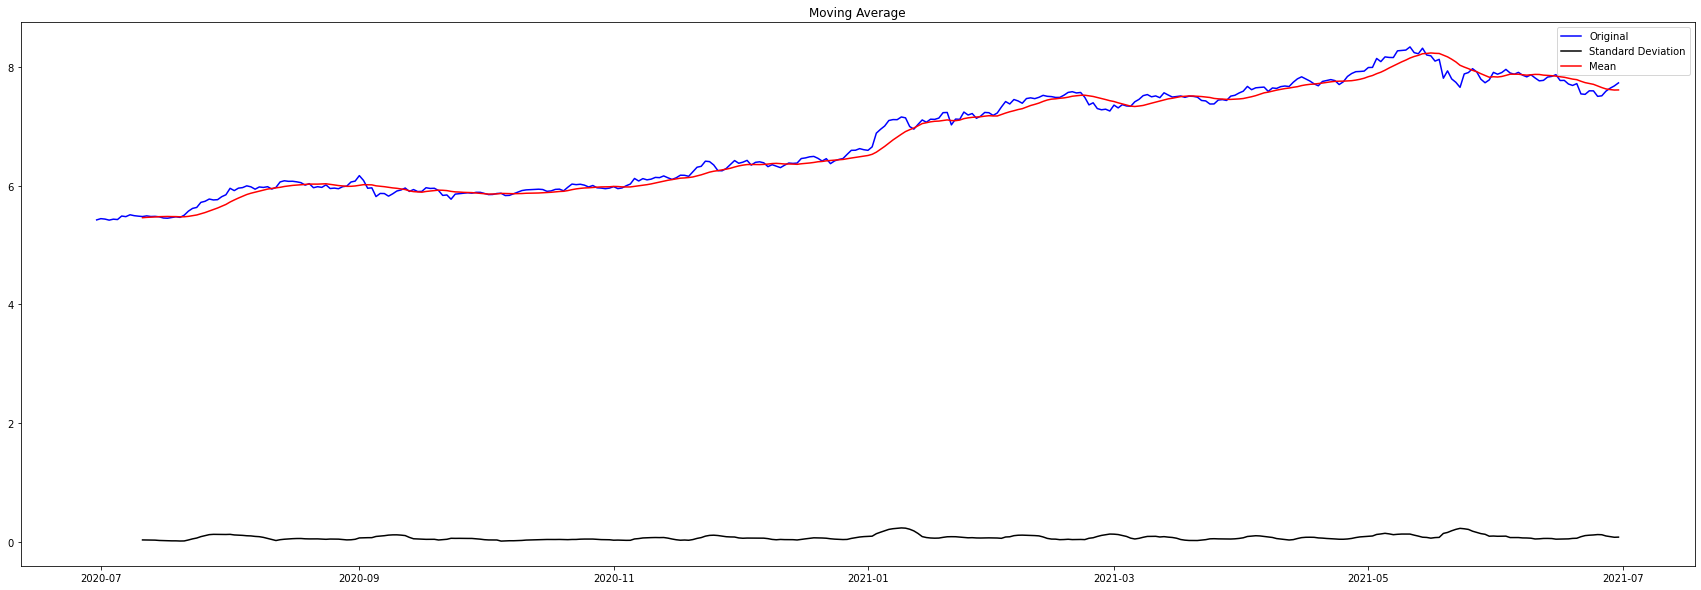

In [13]:
from pylab import rcParams
df_log = np.log(df)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()

plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(df_log, color='blue',label='Original')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

## Arranging Parameters

### d

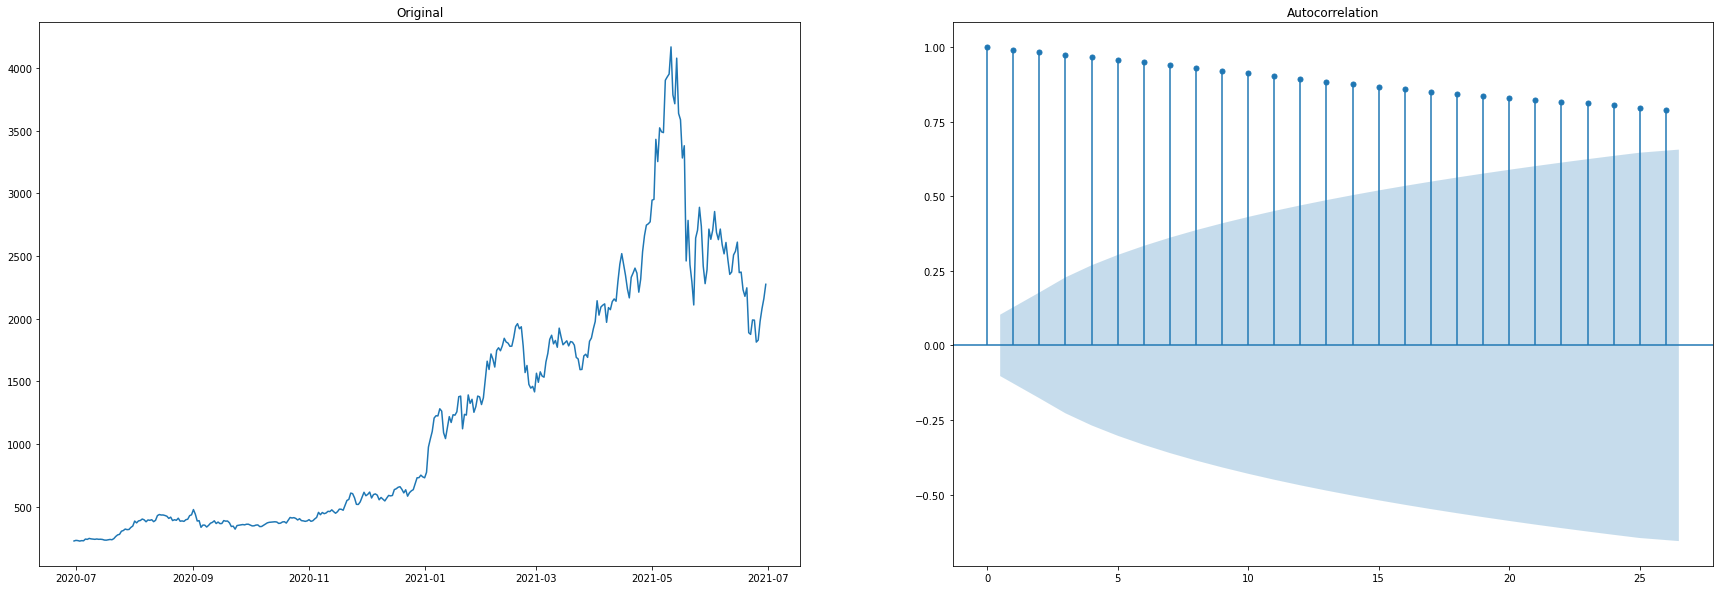

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(df)
ax1.set_title("Original")
# add ; at the end of the plot function so that the plot is not duplicated
plot_acf(df, ax=ax2);

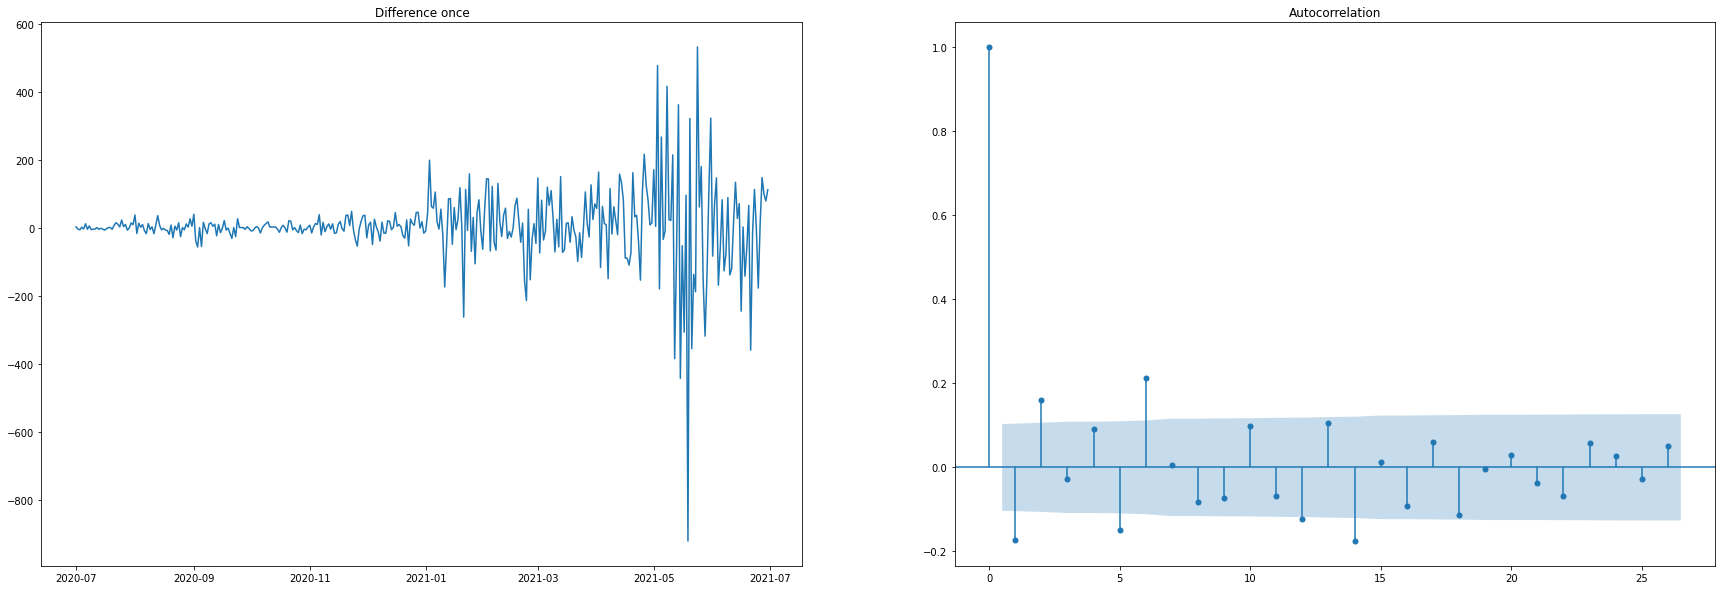

In [15]:
diff = df.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(diff)
ax1.set_title("Difference once")
plot_acf(diff, ax=ax2);

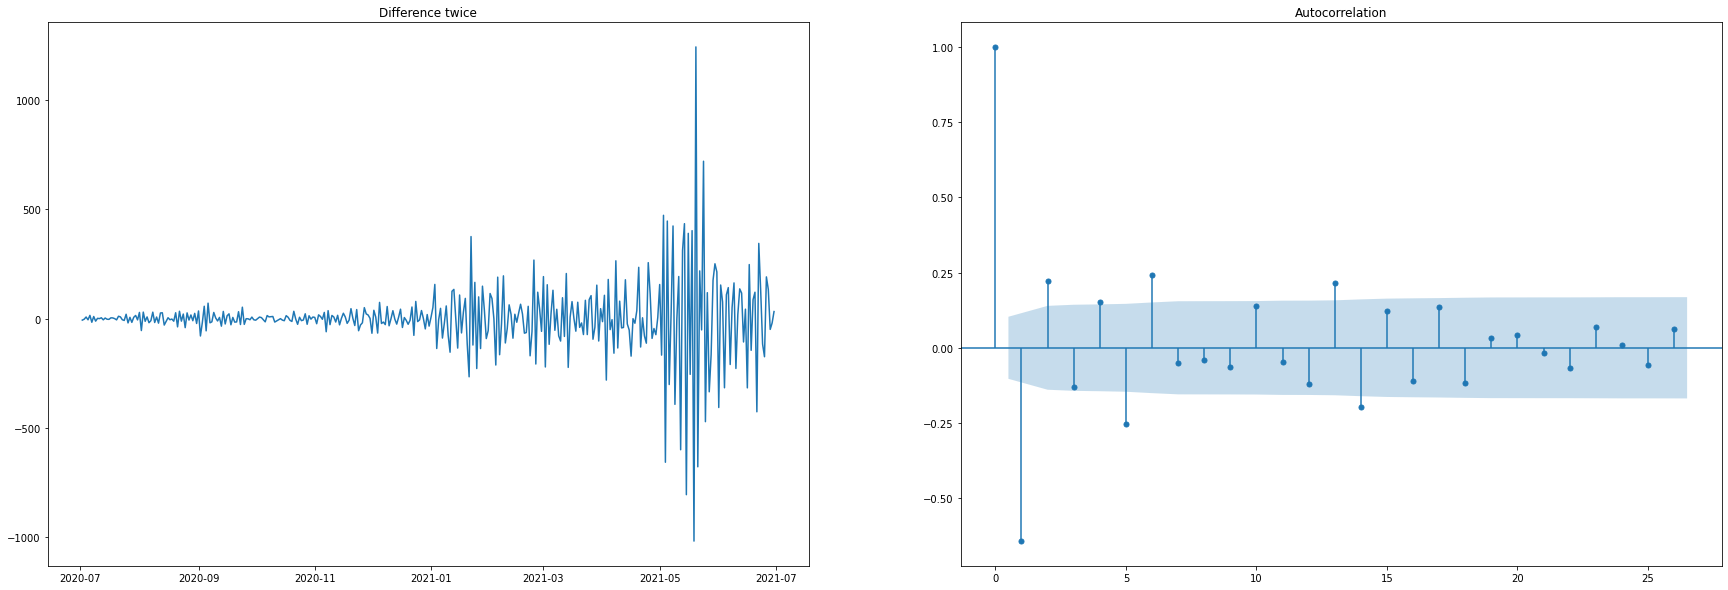

In [16]:
diff = df.diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(diff)
ax1.set_title("Difference twice")
plot_acf(diff, ax=ax2);

### p

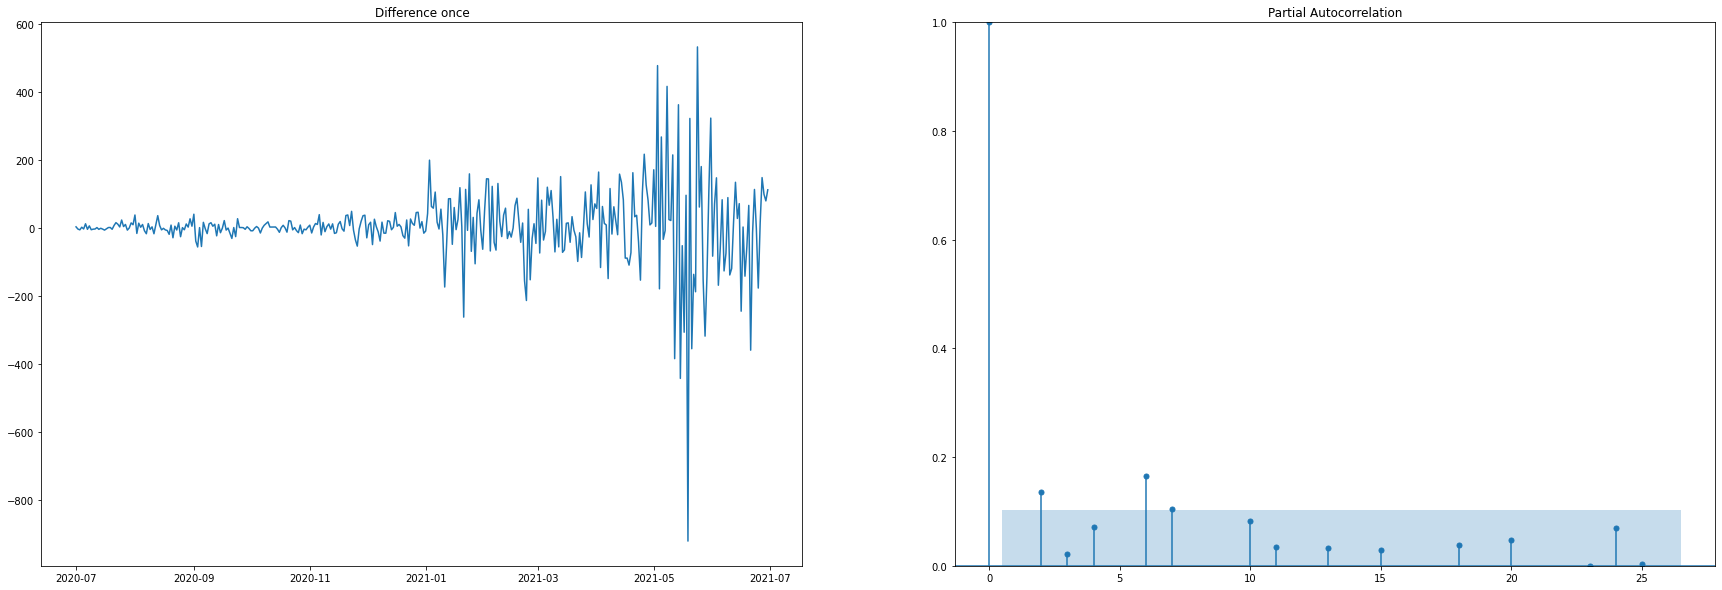

In [17]:
diff = df.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2);

### q

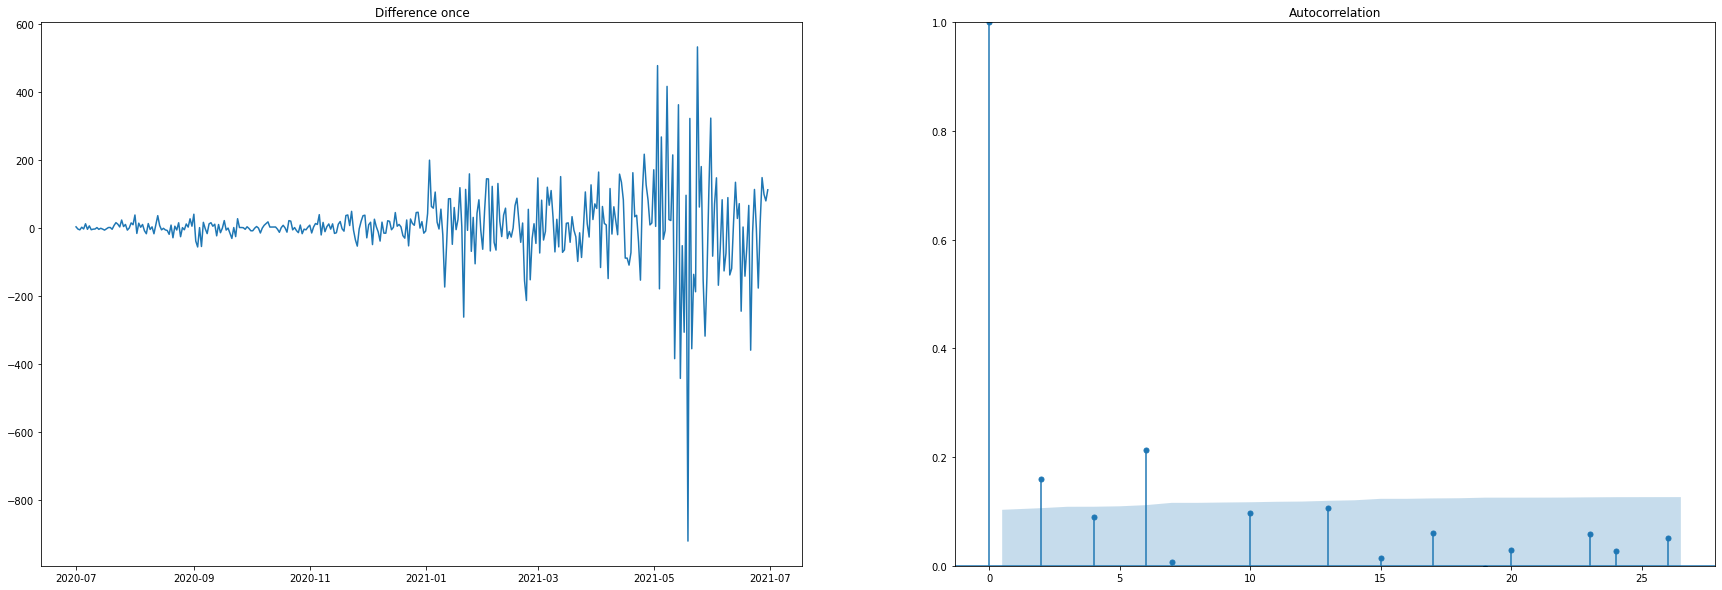

In [18]:
diff = df.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2);

## Arranging Train and Test Sets

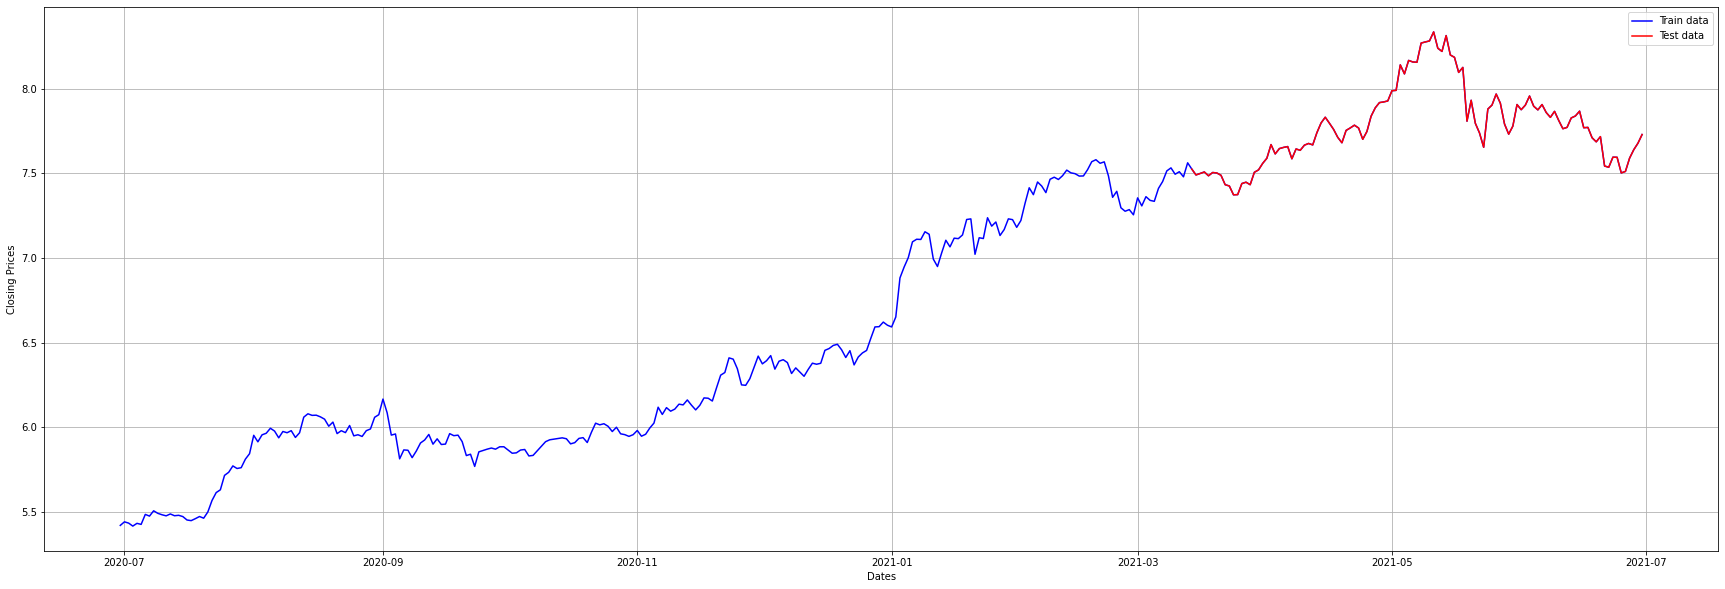

In [19]:
train_data, test_data = df_log[3:int(len(df_log)*0.7)], df_log[int(len(df_log)*0.7):]
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'blue', label='Train data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

## Model Training

In [20]:
history = [x for x in train_data]
model_predictions = []
N_test_observations = len(test_data)

for time_point in range(N_test_observations):
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)

## Prediction & Success Metrics

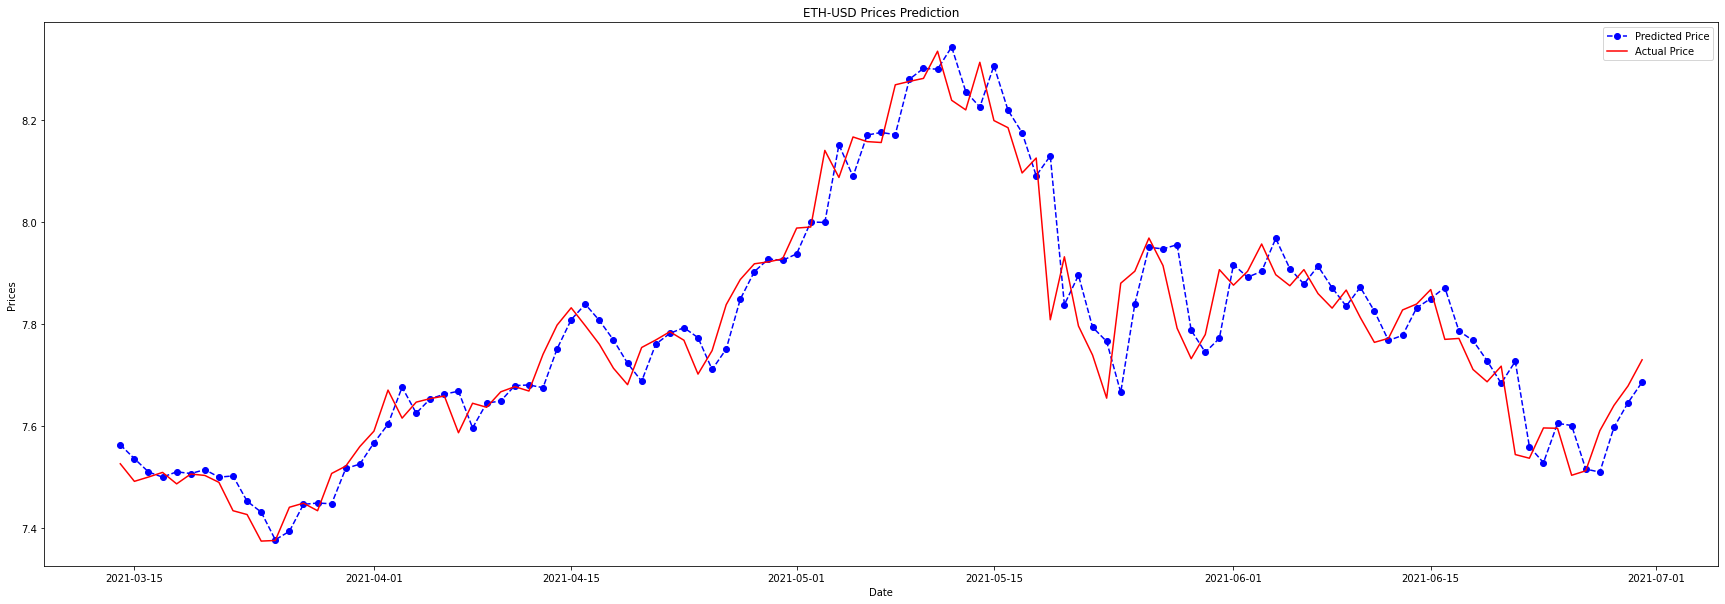

In [21]:
test_set_range = df[int(len(df)*0.7):].index
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('ETH-USD Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

In [22]:
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 0.004611063800696825


# BACKTESTING OF THE MODEL

In [23]:
length = len(model_predictions)
back_test_df = pd.DataFrame()
back_test_df["Prediction"] = model_predictions
back_test_df["Close"] = history[-length:]

In [24]:
back_test_df

,Prediction,Close
0,[7.5627281229924925],7.525405
1,[7.535466921759253],7.490921
2,[7.509441691458962],7.499408
3,[7.499127981315779],7.508485
4,[7.509666809455134],7.485971
...,...,...
104,[7.514982928927695],7.511655
105,[7.509052386850114],7.590294
106,[7.596817683614701],7.639958
107,[7.645336297366528],7.678219


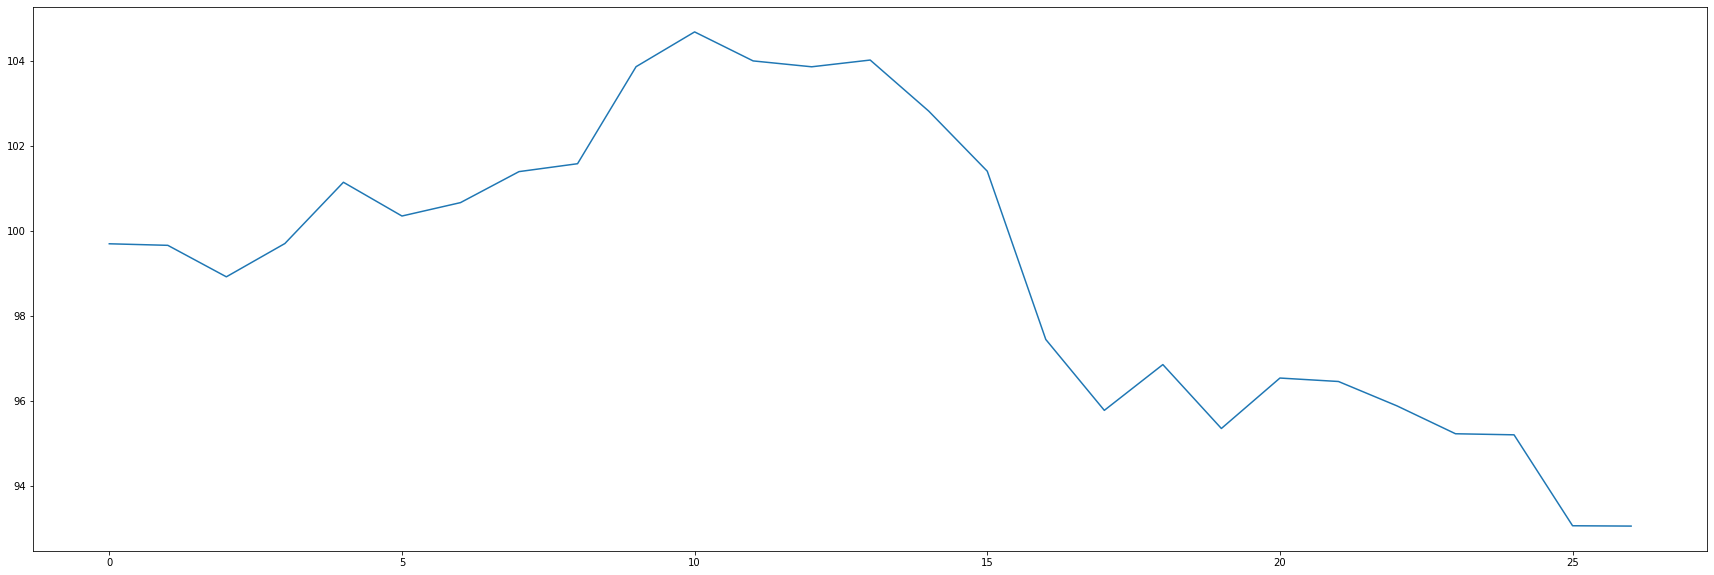

27


In [25]:
curr_wallet = 100
wallet_list = []
in_position = False

for index in range(len(back_test_df["Close"]) - 1):    
    curr_pred = back_test_df["Prediction"].values[index]
    next_pred = back_test_df["Prediction"].values[index + 1]
    curr_close = back_test_df["Close"].values[index]
    
    if next_pred > curr_pred and not in_position:        
        bought_at = curr_close
        # print("bought at ", curr_close)
        in_position = True
    elif next_pred < curr_pred and in_position:        
        sold_at = curr_close
        # print("sold at ", curr_close)
        in_position = False

        profit = ((sold_at - bought_at) / bought_at)  * curr_wallet
        curr_wallet += profit
        wallet_list.append(curr_wallet)


plt.plot(wallet_list)
plt.show()
print(len(wallet_list))        